In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [4]:
train = pd.read_csv('/kaggle/input/ecg-datasets/train_data.csv')
test = pd.read_csv('/kaggle/input/ecg-datasets/test_data.csv')
val = pd.read_csv('/kaggle/input/ecg-datasets/val_data.csv')

# SMOTE Funct/ Oversampling Strategy

In [5]:
def create_tiered_smote_strategy(y, tier_config=None):
    if tier_config is None:
        tier_config = [
            (0, 50, 2.0),      # (min, max, multiplier)
            (50, 100, 1.5),
            (100, 1000, 1.2),
        ]
    
    class_counts = y.value_counts()
    strategy = {}
    print("TIERED SMOTE STRATEGY")
    print(f"{'Class':<8} {'Count':<10} {'Tier':<20} {'Multiplier':<12} {'Target':<10}")
    
    for cls, count in class_counts.items():
        target = count  # default: no change
        tier_name = "No oversampling"
        multiplier = "1.0x"
        
        # Check which tier this class falls into
        for min_thresh, max_thresh, mult in tier_config:
            if min_thresh <= count < max_thresh:
                target = int(count * mult)
                target = max(target, count + 1)  # SMOTE requires at least +1
                tier_name = f"{min_thresh}-{max_thresh} samples"
                multiplier = f"{mult}x"
                strategy[cls] = target
                break
        
        print(f"{cls:<8} {count:<10} {tier_name:<20} {multiplier:<12} {target:<10}")
    
    return strategy

# Undersampling Funct

In [6]:

def create_targeted_undersampling_strategy(y, target_class=0, reduction_factor=0.5):
    class_counts = y.value_counts()
    strategy = {}
    
    print("\n" + "="*80)
    print("UNDERSAMPLING STRATEGY")
    print("="*80)
    print(f"{'Class':<8} {'Original':<10} {'Target':<10} {'Removed':<12} {'Action':<20}")
    print("-"*80)
    
    for cls, count in class_counts.items():
        if cls == target_class:
            target = int(count * reduction_factor)
            strategy[cls] = target
            removed = count - target
            action = f"Reduce by {int((1-reduction_factor)*100)}%"
        else:
            strategy[cls] = count
            target = count
            removed = 0
            action = "Keep all"
        
        print(f"{cls:<8} {count:<10} {target:<10} {removed:<12} {action:<20}")
    
    return strategy

# Preparing Data
# Original Data

In [7]:
# Original data
X_train_original = train.iloc[:, :-1]
y_train_original = train.iloc[:, -1]
scaler = StandardScaler()
scaler.fit(X_train_original.values)  
print("\nOriginal Distribution (labels 0-14):")
print(y_train_original.value_counts().sort_index())

# Label mapping
label_map = {
    0: 'N', 2: 'N', 3: 'N', 4: 'N', 5: 'N',
    6: 'S', 7: 'S', 8: 'S', 9: 'S',
    10: 'V', 12: 'V',
    11: 'F', 1: 'F',
    13: 'Q', 14: 'Q'
}


Original Distribution (labels 0-14):
0.000000.1
0.0     45011
1.0      4215
2.0      4843
3.0      4353
4.0        10
5.0       137
6.0      1528
7.0        90
8.0        49
9.0         2
10.0       64
11.0      481
12.0     4277
13.0      589
14.0       20
Name: count, dtype: int64


**Dataset 1: Undersampling + SMOTE**

In [8]:

print("DATASET 1: TIERED SMOTE + UNDERSAMPLING")
# Step 1: Undersample class 0 (the 45,000 sample class)
undersampling_strategy = create_targeted_undersampling_strategy(
    y_train_original, 
    target_class=0, 
    reduction_factor=0.5
)

rus = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_strategy)
X_temp1, y_temp1 = rus.fit_resample(X_train_original, y_train_original)

print(f"\nAfter undersampling: {len(y_temp1)} samples")

# Step 2: Apply tiered SMOTE
smote_strategy = create_tiered_smote_strategy(y_temp1)

# Calculate safe k_neighbors
min_class_size = y_temp1.value_counts().min()
k_val = min(5, max(1, min_class_size - 1))
print(f"\nUsing k_neighbors={k_val} (smallest class: {min_class_size} samples)")

smote = SMOTE(random_state=42, k_neighbors=k_val, sampling_strategy=smote_strategy)
X_dataset1, y_dataset1_numeric = smote.fit_resample(X_temp1, y_temp1)

# Map to AAMI
y_dataset1 = pd.Series(y_dataset1_numeric).map(label_map)

print(f"\nFinal Dataset 1 size: {len(y_dataset1)} samples")
print("\nAAMI Distribution (Dataset 1):")
print(y_dataset1.value_counts().sort_index())

DATASET 1: TIERED SMOTE + UNDERSAMPLING

UNDERSAMPLING STRATEGY
Class    Original   Target     Removed      Action              
--------------------------------------------------------------------------------
0.0      45011      22505      22506        Reduce by 50%       
2.0      4843       4843       0            Keep all            
3.0      4353       4353       0            Keep all            
12.0     4277       4277       0            Keep all            
1.0      4215       4215       0            Keep all            
6.0      1528       1528       0            Keep all            
13.0     589        589        0            Keep all            
11.0     481        481        0            Keep all            
5.0      137        137        0            Keep all            
7.0      90         90         0            Keep all            
10.0     64         64         0            Keep all            
8.0      49         49         0            Keep all            
14.0     2

**Dataset 2: Duplication Oversampling + Undersampling**

In [9]:
print("DATASET 2: RANDOM OVERSAMPLING (DUPLICATION) + UNDERSAMPLING")
# Step 1: Undersample class 0
rus2 = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_strategy)
X_temp2, y_temp2 = rus2.fit_resample(X_train_original, y_train_original)

# Step 2: Random oversampling with same targets as SMOTE
ros = RandomOverSampler(random_state=42, sampling_strategy=smote_strategy)
X_dataset2, y_dataset2_numeric = ros.fit_resample(X_temp2, y_temp2)

# Map to AAMI
y_dataset2 = pd.Series(y_dataset2_numeric).map(label_map)

print(f"\nFinal Dataset 2 size: {len(y_dataset2)} samples")
print("\nAAMI Distribution (Dataset 2):")
print(y_dataset2.value_counts().sort_index())

DATASET 2: RANDOM OVERSAMPLING (DUPLICATION) + UNDERSAMPLING

Final Dataset 2 size: 43561 samples

AAMI Distribution (Dataset 2):
0.000000.1
F     4792
N    31885
Q      746
S     1765
V     4373
Name: count, dtype: int64


**Dataset 3: No Sampling**

In [10]:
print("DATASET 3: ORIGINAL DATA (NO RESAMPLING)")
X_dataset3 = X_train_original.copy()
y_dataset3 = y_train_original.map(label_map)
print(f"\nFinal Dataset 3 size: {len(y_dataset3)} samples")
print("\nAAMI Distribution (Dataset 3):")
print(y_dataset3.value_counts().sort_index())

DATASET 3: ORIGINAL DATA (NO RESAMPLING)

Final Dataset 3 size: 65669 samples

AAMI Distribution (Dataset 3):
0.000000.1
F     4696
N    54354
Q      609
S     1669
V     4341
Name: count, dtype: int64


**Dataset 4**

In [11]:
print("DATASET 4: UnderSampling & no overscaling")
rus4 = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_strategy)
X_temp4, y_temp4 = rus4.fit_resample(X_train_original, y_train_original)
X_dataset4 = X_temp4
y_dataset4 = y_temp4.map(label_map)
print(f"\nFinal Dataset 4 size: {len(y_dataset4)} samples")
print("\nAAMI Distribution (Dataset 4):")
print(y_dataset4.value_counts().sort_index())

DATASET 4: UnderSampling & no overscaling

Final Dataset 4 size: 43163 samples

AAMI Distribution (Dataset 4):
0.000000.1
F     4696
N    31848
Q      609
S     1669
V     4341
Name: count, dtype: int64


**Preparing Val & Test sets**

In [13]:
test['AAMI'] = test.iloc[:, -2].map(label_map)
val['AAMI'] = val.iloc[:, -2].map(label_map)

X_test = test.iloc[:, :-2]
y_test = test['AAMI']
X_val = val.iloc[:, :-2]
y_val = val['AAMI']

print(f"\nTest set: {len(X_test)} samples")
print(y_test.value_counts().sort_index())
print(f"\nValidation set: {len(X_val)} samples")
print(y_val.value_counts().sort_index())
mask_val = ~y_val.isnull()
X_val = X_val[mask_val]
y_val = y_val[mask_val]

mask_test = ~y_test.isnull()
X_test = X_test[mask_test]
y_test = y_test[mask_test]
print(f"\nTest set: {len(X_test)} samples")
print(y_test.value_counts().sort_index())
print(f"\nValidation set: {len(X_val)} samples")
print("Validation set missing:", any(pd.isnull(y_val)))
print("Test set missing:", any(pd.isnull(y_test)))


Test set: 21890 samples
AAMI
F     1565
N    18119
Q      203
S      556
V     1447
Name: count, dtype: int64

Validation set: 21890 samples
AAMI
F     1566
N    18118
Q      203
S      556
V     1447
Name: count, dtype: int64

Test set: 21890 samples
AAMI
F     1565
N    18119
Q      203
S      556
V     1447
Name: count, dtype: int64

Validation set: 21890 samples
Validation set missing: False
Test set missing: False


In [14]:
X_dataset1_scaled = scaler.transform(X_dataset1.values)
X_dataset2_scaled = scaler.transform(X_dataset2.values)
X_dataset3_scaled = scaler.transform(X_dataset3.values)
X_dataset4_scaled = scaler.transform(X_dataset4.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Data Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Simulation ---
aami_labels = ['F', 'N', 'Q', 'S', 'V']
sample_counts = [4696, 31848, 609, 1669, 4341] # <-------------- CHANGE VALUES HERE FOR DIFFERENT DATASETS!!!!
simulated_distribution = pd.Series(sample_counts, index=aami_labels, name='AAMI Distribution (Dataset 2)')
print("Simulated AAMI Distribution:\n")
print(simulated_distribution)

# --- Plotting ---
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

ax = sns.barplot(x=simulated_distribution.index, y=simulated_distribution.values, palette='viridis')

plt.title('Dataset 4: AAMI Class Distribution after Undersampling & No Overscaling', fontsize=16)
plt.xlabel('AAMI Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.tight_layout()

plt.show()

**Gaussian Plot**

In [ ]:
df_stats = X_train.describe().T  
print(df_stats.head())
 
X_train.stack().hist(bins=100, figsize=(8,4))
plt.title("Distribution of ECG amplitudes (mV)")
plt.xlabel("mV")
plt.ylabel("Frequency")
plt.show()

**ECG Visualization**

In [1]:
import matplotlib.ticker as ticker
unique_labels = np.sort(y_train.unique())
 
print(f"Plotting one example for each of the {len(unique_labels)} unique labels (in ascending order)...")
 
for label in unique_labels:
    index_of_first_occurrence = y_train[y_train == label].index[0]
    signal_to_plot = X_train.loc[index_of_first_occurrence].to_numpy()
 
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(signal_to_plot, linewidth=1.5, color='black')
 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Was 25
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))   # Was 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))   # Was 10
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))   
 
    ax.grid(which='major', linestyle='-', linewidth=0.7, color='#ff9999')
    ax.grid(which='minor', linestyle=':', linewidth=0.4, color='#ffcccb')
 
    ax.set_title(f'ECG Signal for Label: Normal', fontsize=14)
    ax.set_xlabel("Sample Point")
    ax.set_ylabel(f"Class Normal Amplitude (mV)")
 
    plt.show()

**Important libraries**

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

In [16]:
print("Training set missing:", any(pd.isnull(y_dataset1)))
print("Training set missing:", any(pd.isnull(y_dataset2)))
print("Training set missing:", any(pd.isnull(y_dataset3)))
print("Training set missing:", any(pd.isnull(y_dataset4)))
print("Validation set missing:", any(pd.isnull(y_val)))
print("Test set missing:", any(pd.isnull(y_test)))

Training set missing: False
Training set missing: False
Training set missing: False
Training set missing: False
Validation set missing: False
Test set missing: False


In [18]:
le = LabelEncoder()

y_dataset1_enc = le.fit_transform(y_dataset1)
y_dataset2_enc = le.fit_transform(y_dataset2)
y_dataset3_enc = le.fit_transform(y_dataset3)
y_dataset4_enc = le.fit_transform(y_dataset4)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

datasets_enc = {
    "Dataset1": (X_dataset1_scaled, y_dataset1_enc),
    "Dataset2": (X_dataset2_scaled, y_dataset2_enc),
    "Dataset3": (X_dataset3_scaled, y_dataset3_enc),
    "Dataset4": (X_dataset4_scaled, y_dataset4_enc)
}

# HyperParameter for Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'max_depth': [None] + list(np.arange(5, 31, 1)),
    'min_samples_split': np.arange(2, 21, 1),
    'min_samples_leaf': np.arange(1, 11, 1)
}

for name, (X_train, y_train) in datasets_enc.items():
    print(f"\n--- Decision Tree on {name} ---")
    dt = DecisionTreeClassifier(random_state=42)
    dt_search = RandomizedSearchCV(
        estimator=dt,
        param_distributions=dt_params,
        n_iter=20,
        cv=3,
        scoring='recall_macro',
        random_state=42,
        n_jobs=-1
    )
    dt_search.fit(X_train, y_train)
    val_recall = dt_search.score(X_val_scaled, y_val_enc)
    print("Best params:", dt_search.best_params_)
    print("Validation recall:", val_recall)


**Training for Decision Tree**

Decision Tree Performance on Test Set:
Accuracy:  0.9550
Precision: 0.8161
Recall:    0.8292
F1 Score:  0.8224

Per-Class Metrics:
Class    Precision    Recall       F1-Score    
--------------------------------------------
F        0.9266       0.9272       0.9269      
N        0.9772       0.9760       0.9766      
Q        0.6620       0.7044       0.6826      
S        0.6345       0.6745       0.6539      
V        0.8803       0.8639       0.8720      

Confusion Matrix:
 [[ 1451    67    11     4    32]
 [   67 17685    53   193   121]
 [    7    47   143     1     5]
 [    3   165     1   375    12]
 [   38   133     8    18  1250]]


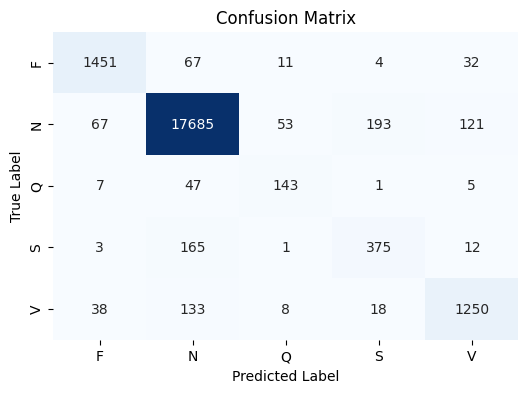

In [19]:
dt_model = DecisionTreeClassifier(
    min_samples_split=18,
    min_samples_leaf=7,
    max_depth=None,
    random_state=42
)
# Train model
dt_model.fit(X_dataset2_scaled, y_dataset2_enc)
# Predict
y_pred = dt_model.predict(X_test_scaled)
# Metrics
acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
cm = confusion_matrix(y_test_enc, y_pred)

# Per-class metrics
prec_per_class = precision_score(y_test_enc, y_pred, average=None)
rec_per_class = recall_score(y_test_enc, y_pred, average=None)
f1_per_class = f1_score(y_test_enc, y_pred, average=None)

# Print metrics
print("Decision Tree Performance on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_names = le.classes_

# Per-class metrics
print("\n" + "="*50)
print("Per-Class Metrics:")
print("="*50)
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*44)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<8} {prec_per_class[i]:<12.4f} {rec_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f}")

print("\nConfusion Matrix:\n", cm)

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Hyperparameter for Random Forest

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': np.arange(50, 301, 10),        # 50→300
    'max_depth': [None] + list(np.arange(5, 31, 1)), # None or 5→30
    'min_samples_split': np.arange(2, 21, 1),
    'min_samples_leaf': np.arange(1, 11, 1)
}

for name, (X_train, y_train) in datasets_enc.items():
    print(f"\n--- Random Forest on {name} ---")
    rf = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=rf_params,
        n_iter=20,  # randomly sample 20 combinations
        cv=3,       # internal CV
        scoring='recall_macro',
        random_state=42,
        n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    val_recall = rf_search.score(X_val_scaled, y_val_enc)
    print("Best params:", rf_search.best_params_)
    print("Validation recall:", val_recall)

**Training/ Testing RF**

In [ ]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=12,
    min_samples_leaf=2,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_dataset2_scaled, y_dataset2_enc)

# Predict
y_pred = rf_model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
cm = confusion_matrix(y_test_enc, y_pred)

# Print metrics Per Class
print("Random Forest Performance on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
class_names = le.classes_

# Confusion matrix 
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [7]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

cm = np.array([
    [1492,   57,    0,    0,   16],
    [   7, 18051,   5,   12,   44],
    [   6,   40,  157,    0,    0],
    [   2,  165,    0,  387,    2],
    [  16,  104,    1,    0, 1326]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = np.repeat(np.arange(5), cm.sum(axis=1))
y_pred = np.concatenate([np.repeat(j, cm[i, j]) for i in range(5) for j in range(5)])

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

classes = ['N', 'S', 'V', 'F', 'Q']

print(f"Precision per class:\n{dict(zip(classes, precision))}\n")
print(f"Recall per class:\n{dict(zip(classes, recall))}\n")
print(f"F1-Score per class:\n{dict(zip(classes, f1))}")

Precision per class:
{'N': 0.979645436638214, 'S': 0.9801270565238638, 'V': 0.9631901840490797, 'F': 0.9699248120300752, 'Q': 0.9553314121037464}

Recall per class:
{'N': 0.9533546325878595, 'S': 0.9962470335007451, 'V': 0.7733990147783252, 'F': 0.6960431654676259, 'Q': 0.9163787145818936}

F1-Score per class:
{'N': 0.966321243523316, 'S': 0.9881213050142325, 'V': 0.8579234972677596, 'F': 0.8104712041884816, 'Q': 0.9354497354497354}


# Deep Neural Network (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, make_scorer
mlp_params = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (32,32), (64,32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],            # 'adam' is standard
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate_init': [0.001, 0.005, 0.01],
    'max_iter': [100, 200],
    'batch_size': [16, 32, 64]
}

recall_scorer = make_scorer(recall_score, average='macro')

for name, (X_train, y_train) in datasets_enc.items():
    print(f"\n--- MLP on {name} ---")
    
    # Initialize MLPClassifier
    mlp = MLPClassifier(random_state=42)
    
    # Randomized search
    mlp_search = RandomizedSearchCV(
        estimator=mlp,
        param_distributions=mlp_params,
        n_iter=10,
        cv=3,
        scoring=recall_scorer,
        random_state=42,
        n_jobs=1,
        verbose=1
    )
    
    # Fit on training set only
    mlp_search.fit(X_train, y_train)
    
    # Evaluate on separate validation set
    val_recall = recall_score(y_val_enc, mlp_search.predict(X_val_scaled), average='macro')
    
    print("Best params:", mlp_search.best_params_)
    print(f"Validation recall: {val_recall:.4f}")


**MLP Training/ Testing**

MLP Classifier Performance on Test Set:
Accuracy:  0.9842
Precision: 0.9437
Recall:    0.9318
F1 Score:  0.9377
Per-Class Metrics:
Class    Precision    Recall       F1-Score    
F        0.9856       0.9604       0.9728      
N        0.9900       0.9935       0.9918      
Q        0.9141       0.8916       0.9027      
S        0.8644       0.8597       0.8620      
V        0.9644       0.9537       0.9590      

Confusion Matrix:
 [[ 1503    44     2     0    16]
 [   10 18002     9    68    30]
 [    2    16   181     3     1]
 [    1    73     0   478     4]
 [    9    48     6     4  1380]]


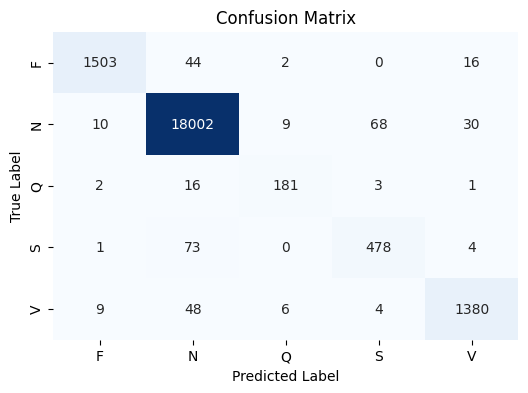

In [20]:
mlp_model = MLPClassifier(
    solver='adam',
    max_iter=200,  # 200 for Dataset3 or 100 otherwise
    learning_rate_init=0.001,
    hidden_layer_sizes=(128,),
    batch_size=64,
    alpha=0.0001,
    activation='relu',  # use 'relu' for Dataset3
    random_state=42
)
# Train model (use scaled data)
mlp_model.fit(X_dataset3_scaled, y_dataset3_enc)
# Predict
y_pred = mlp_model.predict(X_test_scaled)
# Metrics
acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
cm = confusion_matrix(y_test_enc, y_pred)

# Per-class metrics
prec_per_class = precision_score(y_test_enc, y_pred, average=None)
rec_per_class = recall_score(y_test_enc, y_pred, average=None)
f1_per_class = f1_score(y_test_enc, y_pred, average=None)

# Print metrics
print("MLP Classifier Performance on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_names = le.classes_

# Per-class metrics
print("Per-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<8} {prec_per_class[i]:<12.4f} {rec_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f}")

print("\nConfusion Matrix:\n", cm)

#Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200,
    min_samples_split=12,
    min_samples_leaf=2,
    max_depth=None,
    random_state=42,
    n_jobs=-1)),
    ('dt', DecisionTreeClassifier(min_samples_split=18,
    min_samples_leaf=7,
    max_depth=None,
    random_state=42))
]
Stack = StackingClassifier(
    estimators=estimators, final_estimator=DecisionTreeClassifier(min_samples_split=18,
    min_samples_leaf=7,
    max_depth=None,
    random_state=42), cv = 10
)
Stack.fit(X_dataset2_scaled, y_dataset2_enc)
y_pred = Stack.predict(X_test_scaled)
acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
cm = confusion_matrix(y_test_enc, y_pred)

# Print metrics
print("Random Forest Performance on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
class_names = le.classes_

# --- Plot decoded confusion matrix ---
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Scores per class**

In [23]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
cm = np.array([
    [ 1497,    43,     2,     0,    23],
 [   53, 17854,    10,   125,    77],
 [    1 ,   23,   179,     0,     0,],
 [    6,   139,     0,   408,     3],
 [   26,   85,     3,     2,  1331]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = np.repeat(np.arange(5), cm.sum(axis=1))
y_pred = np.concatenate([np.repeat(j, cm[i, j]) for i in range(5) for j in range(5)])

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

classes = ['N', 'S', 'V', 'F', 'Q']

print(f"Precision per class:\n{dict(zip(classes, precision))}\n")
print(f"Recall per class:\n{dict(zip(classes, recall))}\n")
print(f"F1-Score per class:\n{dict(zip(classes, f1))}")

Precision per class:
{'N': 0.9456727732154138, 'S': 0.9840167548500882, 'V': 0.9226804123711341, 'F': 0.7626168224299066, 'Q': 0.9281729428172942}

Recall per class:
{'N': 0.9565495207667731, 'S': 0.9853744687896683, 'V': 0.8817733990147784, 'F': 0.7338129496402878, 'Q': 0.9198341395991707}

F1-Score per class:
{'N': 0.9510800508259212, 'S': 0.9846951438104955, 'V': 0.9017632241813602, 'F': 0.7479376718606783, 'Q': 0.9239847275251649}
